# Update the VirtualBox to install *graphviz* and *pydotplus*

In [ ]:
import sys
e = sys.executable
pip = "/".join(e.split("/")[:-1])+"/pip"
!pip install scikit-learn==0.22
!pip install graphviz
!pip install pydotplus

In [ ]:
!sudo apt update
!sudo apt install graphviz --yes --fix-missing

# Decision Trees

* Nonparametric statistical learning method for classification and regression
* No need formal distributional assumptions
* Simple to understand and interpret
* Can be displayed graphically
* Require little data preparation
* Can handle huge datasets
* Can handle quantitative and qualitative features
* Ignore redundant variables easily
* Trees can change a lot if we change the data a little (instability)
* Generally do not have good predictive performance
* But, by ensembling many decision trees, using **_bagging_**, **_random forests_**, or **_boosting_**, the predictive performance improves substantially.

### Some Theory

* Decision trees predict $Y$ by learning **_decision rules_** from $\small{\mathbf{\boldsymbol{X}} = (X_1,\ldots,X_p)\in\mathcal{X}}$

* Binary recursive partitioning of $\mathcal{X}$ into finite disjoint regions (also nodes or leafs), $\small{R_1,\ldots,R_T}$

$$\mathcal{X}=\cup_{t=1}^TR_t,\quad R_t\cap R_{t'}=\varnothing,\ \forall t\neq t',$$

and fit $Y$ by a simple model in each one.

* Each region $R_t$ has sides parallel to axes of $\mathcal{X}$, where in each $R_t$ a class (for a classification problem) or a constant (for a regression problem) is assigned.


<img src='decisiontree.png' width='800' />

Source: Louppe (2014). *Understanding Random Forests: From Theory to Practice*. PhD. thesis, University of Liège, Faculty of Applied Sciences, Department of Electrical Engineering & Computer Science, Liège, Belgium.

* Tree models are written as

$$f(\boldsymbol{x}_i) := f\left(\boldsymbol{x}_i, \{w_t,R_t\}_{t=1}^T \right) = \sum_{t=1}^{T} w_tI(\boldsymbol{x}_i\in R_t),$$

where $w_t$ is constant (weight or score) in each terminal node, and
$$
I(\boldsymbol{x}_i\in R_t)=
\begin{cases}
0, & \boldsymbol{x}_i\notin R_t\\
1, & \boldsymbol{x}_i\in R_t
\end{cases}
$$

#### Regression trees

* The empirical generalization error is given by

$$
\begin{split}
\widehat{\mathrm{Err}}(f)
&=\sum_{t=1}^{T}p(t)\left[ \frac{1}{n_t}\sum_{\boldsymbol{x}_i\in R_t}(y_i-\hat{w}_t)^2\right] \\
&=\frac{1}{n}\sum_{t=1}^{T}\sum_{\boldsymbol{x}_i\in R_t}(y_i-\hat{w}_t)^2,
\end{split}
$$

where $p(t)=n_t/n$, $\hat{w}_t=n_t^{-1}\sum_{\boldsymbol{x}_i\in R_t}y_i$, and $n_t=\#\{\boldsymbol{x}_i\in R_t\}$.

$\small{i_\mathrm{R}(t)=1/n_t\sum_{\boldsymbol{x}_i\in R_t}(y_i-\hat{w}_t)^2}$ is called the *squared error node impurity*.

#### Classification trees

Assuming an 0-1 loss function, the empirical generalization error is given by

$$
\widehat{\mathrm{Err}}(f)=\sum_{t=1}^{T}p(t)[1-p(\hat{w}_t|t)]
$$

where $\hat{w}_t=\arg\min_{k\in\mathcal{Y}}1-p(k|t)$, with $\small{p(k|t)=n_{kt}/n_t}$, $\small{n_{kt}=\#\{y_i=k,\boldsymbol{x}_i\in R_t\}}$.

$\small{i_\mathrm{M}(t)=1-p(k|t)}$ is called the *misclassification error impurity function*.

#### Other impurity functions for classification:

* Gini diversity index
$$i_\mathrm{G}(t)=\sum_{k=1}^Kp(k|t)\left( 1-p(k|t)\right)$$

* Cross-entropy
$$i_\mathrm{E}(t)=-\sum_{k=1}^Kp(k|t)\log_2p(k|t)$$
 
The impurity evaluates the goodness of node $t$ (i.e., smaller $i(t)$, purer the node and better predictions $\hat{y}_t=f(\boldsymbol{x}),\boldsymbol{x}\in R_t$).

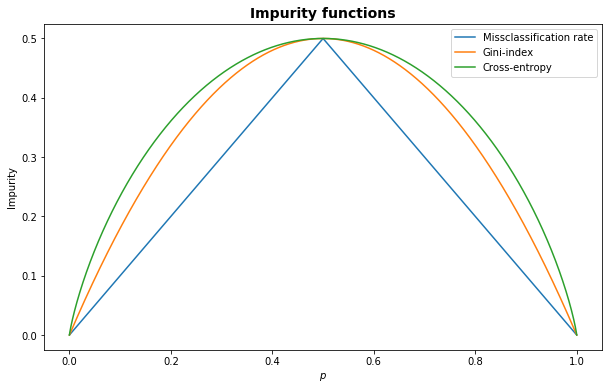

In [2]:
import matplotlib.pyplot as plt
import numpy as np

p = np.arange(0.00001, 1, 0.00001)
mis_rate = np.minimum(p,1-p)
gini = 2*p*(1-p)
entropy = -(p*np.log(p) + (1-p)*np.log(1-p))/ (2*np.log(2))

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=False)
ax.plot(p, mis_rate, label='Missclassification rate')
ax.plot(p, gini, label='Gini-index')
ax.plot(p, entropy, label='Cross-entropy')
plt.ylabel('Impurity')
plt.xlabel(r'$p$')
plt.title('Impurity functions', fontdict={'weight':'bold', 'size':14})
plt.legend(loc='upper right')
plt.show()

####  Impurity decrease

* The impurity decrease of a binary split $s\in\mathcal{S}$ divides the *parent node* $t$ into left $t_\mathrm{L}$ and right $t_\mathrm{R}$ *daughter nodes*

$$\Delta i(s,t) = i(t) -p_\mathrm{L} i(t_\mathrm{L}) - p_\mathrm{R} i(t_\mathrm{R})\geq 0,$$

where $\small{p_\mathrm{L}=n_{t_\mathrm{L}}/n_t}$ and $\small{p_\mathrm{R}=n_{t_\mathrm{R}}/n_t}$ are the proportions of samples in $t_\mathrm{L}$ and $t_\mathrm{R}$, respectively.

* The best split for a feature $X_j$ that partitions $\mathcal{D}_t$,

$$\hat{s}_j =\arg\max_{s\in\mathcal{S}_j} \Delta i(s,t),$$

where $\mathcal{S}_j$ is the set of possible different splits for $X_j$.

## Application

The data includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms (8124 instances) in the Agaricus and Lepiota Family. Each species is identified as edible (classes = e) or poisonous (classes = p).

**Features:**

1. *cap-shape*: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
2. *cap-surface*: fibrous=f, grooves=g, scaly=y, smooth=s
3. *cap-color*: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
4. *bruises*: bruises=t, no=f
5. *odor*: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
6. *gill-attachment*: attached=a, descending=d, free=f, notched=n
7. *gill-spacing*: close=c, crowded=w, distant=d
8. *gill-size*: broad=b, narrow=n
9. *gill-color*: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
10. *stalk-shape*: enlarging=e, tapering=t
11. *stalk-root*: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
12. *stalk-surface-above-ring*: fibrous=f, scaly=y, silky=k, smooth=s
13. *stalk-surface-below-ring*: fibrous=f, scaly=y, silky=k, smooth=s
14. *stalk-color-above-ring*: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
15. *stalk-color-below-ring*: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
16. *veil-type*: partial=p, universal=u
17. *veil-color*: brown=n, orange=o, white=w, yellow=y
18. *ring-number*: none=n, one=o, two=t
19. *ring-type*: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
20. *spore-print-color*: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
21. *population*: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
22. *habitat*: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

*Source: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/Mushroom/). Irvine, CA: University of California, School of Information and Computer Science.*

# Load data

In [8]:
from pandas import read_csv

names = ["classes","cap-shape","cap-surface","cap-color","bruises","odor","gill-attachment","gill-spacing","gill-size","gill-color","stalk-shape","stalk-root","stalk-surface-above-ring","stalk-surface-below-ring","stalk-color-above-ring","stalk-color-below-ring","veil-type","veil-color","ring-number","ring-type","spore-print-color","population","habitat"]
data = read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', names=names)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
classes                     8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [9]:
data.describe()

,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [10]:
data = data.drop(columns=['veil-type']) # remove "veil-type" due to it is constant
data.head()
#data = data.astype('str')

,classes,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


# Split into train and test datasets

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['classes'])
y = data['classes']
#y = y.values.reshape((len(y), 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

print('Train:', X_train.shape, y_train.shape)
print('Test:',  X_test.shape, y_test.shape)

Train: (5686, 21) (5686,)
Test: (2438, 21) (2438,)


In [12]:
# Check the balance of classes
print('Classes prop.:', y.value_counts()/y.shape[0], sep='\n')
print('\n', 'Train classes prop.:', y_train.value_counts()/y_train.shape[0], sep='\n')
print('\n', 'Test classes prop.:',  y_test.value_counts()/y_test.shape[0],   sep='\n')

Classes prop.:
e    0.517971
p    0.482029
Name: classes, dtype: float64


Train classes prop.:
e    0.511432
p    0.488568
Name: classes, dtype: float64


Test classes prop.:
e    0.533224
p    0.466776
Name: classes, dtype: float64


### In case of imbalance, apply some balance algorithm (see https://imbalanced-learn.org/)

# Encode categorical variables

In [13]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# encode categorical features as an integer array
#def prepare_inputs(X_train, X_test):
#    oe = OrdinalEncoder()
#    oe.fit(X_train)
#    X_train_enc = oe.transform(X_train)
#    X_test_enc = oe.transform(X_test)
#    return X_train_enc, X_test_enc

# one-hot encoding of categorical features
#def prepare_inputs(X_train, X_test):
#    ohe = OneHotEncoder()
#    ohe.fit(X_train)
#    X_train_enc = ohe.transform(X_train)
#    X_test_enc = ohe.transform(X_test)
#    return X_train_enc, X_test_enc

# Also
#import pandas as pd
def prepare_inputs(X_train, X_test):
    X_train_enc = pd.get_dummies(X_train, columns=X_train.columns, drop_first=False)
    X_test_enc  = pd.get_dummies(X_test,  columns=X_test.columns,  drop_first=False)
    return X_train_enc, X_test_enc

# encode target labels with values between 0 and n_classes-1
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc  = le.transform(y_test)
    return y_train_enc, y_test_enc

X_train, X_test = prepare_inputs(X_train, X_test)
y_train, y_test = prepare_targets(y_train, y_test)

print('X train:', X_train.shape)
print('X test:', X_test.shape)

X_train.head()

X train: (5686, 116)
X test: (2438, 116)


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
886,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
6692,0,0,1,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
3209,0,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1026,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4818,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0


# Training a decision tree

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# tree's specification
f = DecisionTreeClassifier(
                           criterion='gini',    # 'gini' or 'entropy' impurity functions
                           max_depth=None,      # maximum depth of the tree
#                          min_samples_split=2, # minimum number of samples required to split an internal node
                           min_samples_leaf=1,  # minimum number of samples required to be at a leaf node
                           random_state=77      # the seed used by the random number generator
                          )

# training
f = f.fit(X_train, y_train)

# rules of the decision tree
feature_names = list(X_train.columns) # features' names to plot the tree
ft = export_text(f, feature_names=feature_names)
print(ft)

|--- odor_n <= 0.50
|   |--- stalk-root_c <= 0.50
|   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |--- spore-print-color_u <= 0.50
|   |   |   |   |--- odor_a <= 0.50
|   |   |   |   |   |--- odor_l <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- odor_l >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- odor_a >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- spore-print-color_u >  0.50
|   |   |   |   |--- class: 0
|   |   |--- stalk-surface-below-ring_y >  0.50
|   |   |   |--- class: 0
|   |--- stalk-root_c >  0.50
|   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |--- class: 0
|   |   |--- stalk-surface-below-ring_y >  0.50
|   |   |   |--- class: 1
|--- odor_n >  0.50
|   |--- spore-print-color_r <= 0.50
|   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |--- cap-surface_g <= 0.50
|   |   |   |   |--- gill-size_b <= 0.50
|   |   |   |   |   |--- population_c <= 0.50
|   |   |   |   |   |   |--- class: 0

# Tree plot

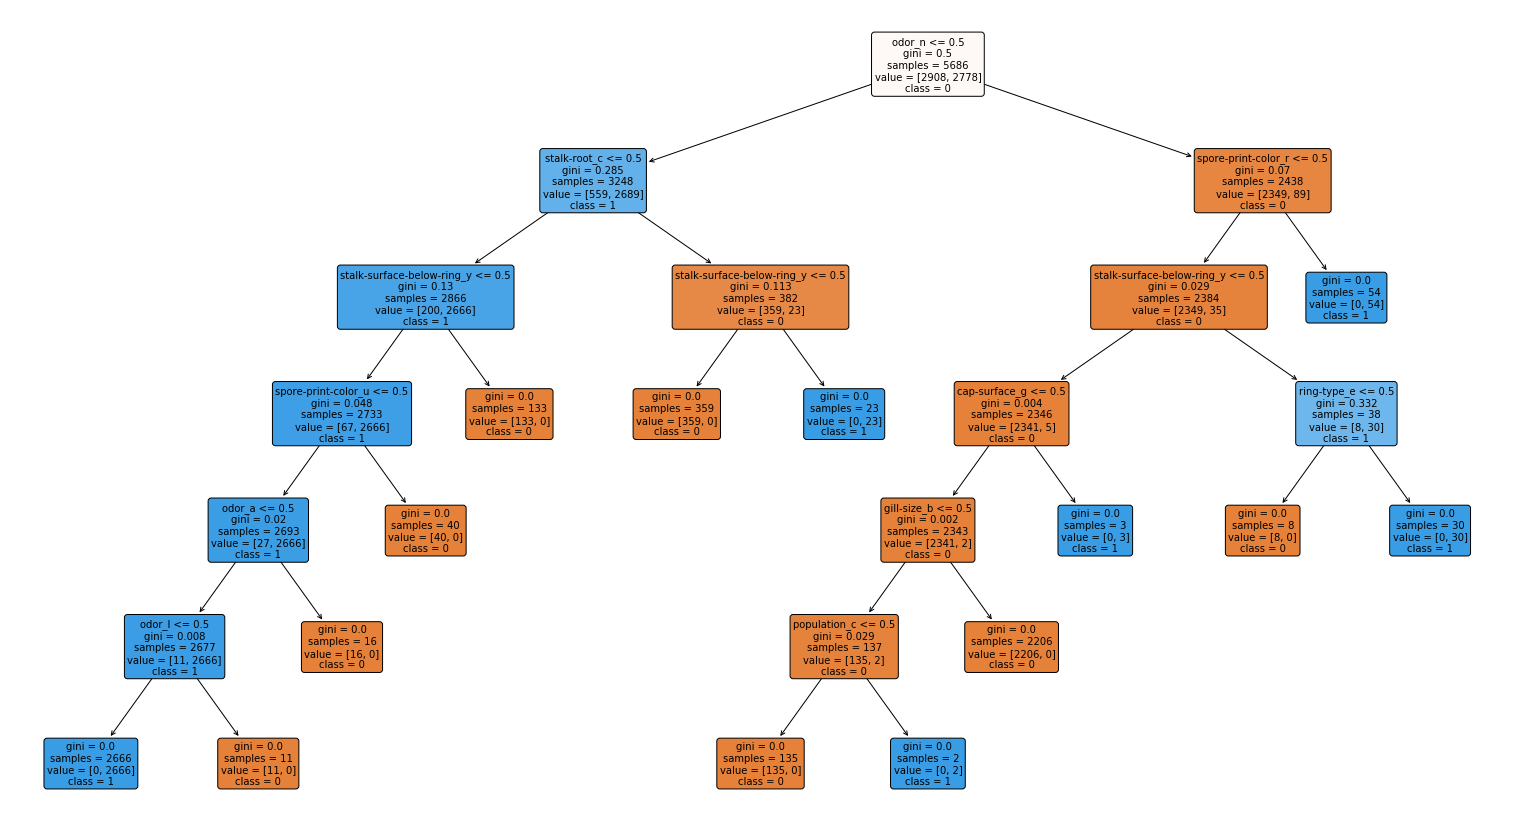

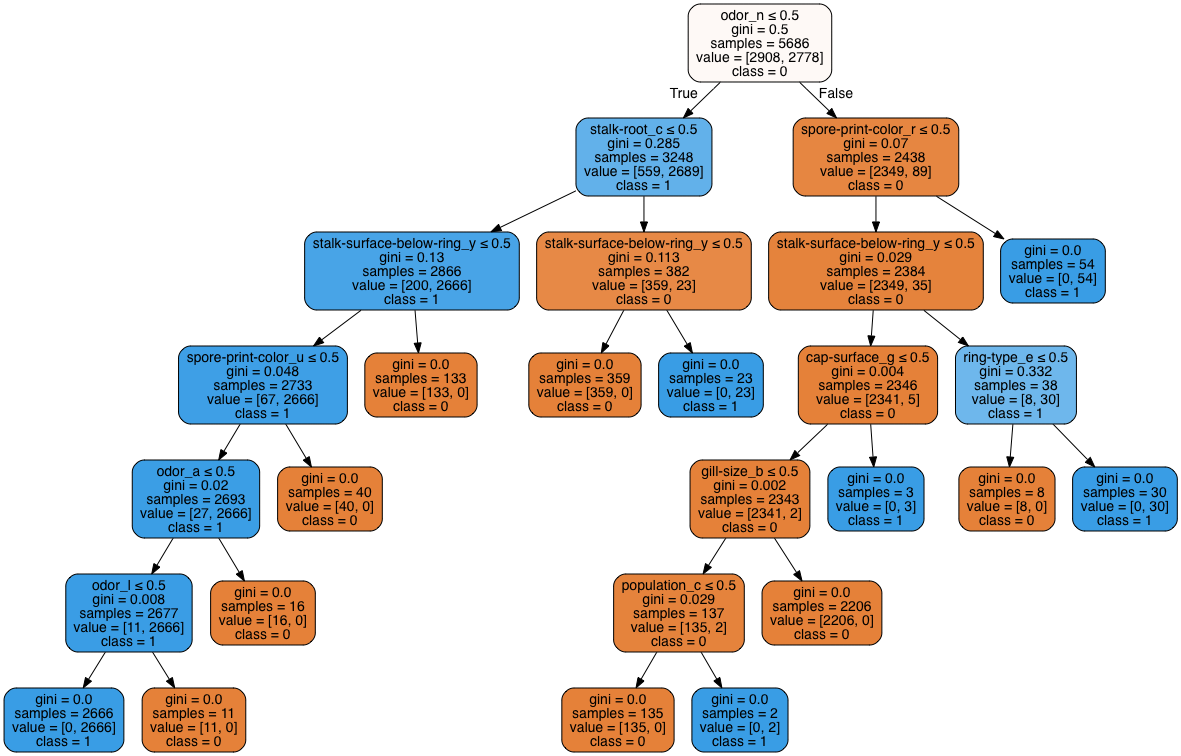

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=[27, 15])
plot_tree(
          f,
          filled=True,
          feature_names=feature_names,
          class_names=['0','1'],
          rounded=True,
          fontsize=10
         )
plt.show()

# A better plot
#
#On mac, use Brew to install graphviz and not pip: graphviz (http://www.graphviz.org/download/), and brew installation (https://brew.sh/)
#brew install graphviz
#pip install pydotplus

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(
                f,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = feature_names,
                class_names=['0','1']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('tree.png')
Image(graph.create_png())

# Cost complexity pruning 

* Grow a large tree $f_0$ by splitting the nodes repeatedly until each $R_t$ has a minimum number of instances, $n(R_t)\leq n_{min}\ (\mathrm{e.g.}=5)$.
* Prune $f_0$ by a subtree $f_\alpha\subseteq f_0$ s.t. min. the cost complexity measure

$$
\mathrm{Err}_\alpha(f) = \sum_{t=1}^{T}\mathrm{Err}_t(f)  + \alpha|f|,\quad \alpha\geq 0,
$$

where $|f|$ denotes the number of terminal nodes in $f$.

* The complexity parameter $\alpha$ controls the trade-off between the tree size and its goodness of fit to data: 

	* $\alpha\to0\ \: \Rightarrow$ a large tree (i.e. $\alpha=0\Rightarrow f_0$).
	* $\alpha\to\infty\Rightarrow$ a very small tree.

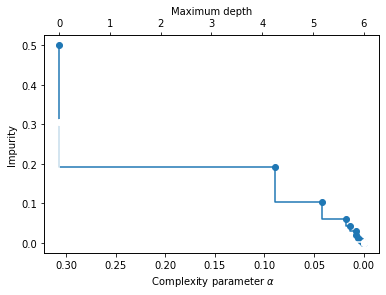

,alpha,Imputiry,Nodes,Depth
0,0.000000,0.000000,27,6
1,0.000351,0.000703,23,6
2,0.001052,0.001755,21,6
3,0.002222,0.003976,19,6
4,0.003853,0.007830,17,5
5,0.005549,0.013378,15,4
6,0.007603,0.020981,13,4
7,0.008154,0.029135,11,4
8,0.013587,0.042722,9,3
9,0.018032,0.060754,7,3


In [17]:
f.get_n_leaves() # number of leaves of the tree
f.get_depth()    # depth of the tree

f_alpha = f.cost_complexity_pruning_path(X_train, y_train)
alphas = f_alpha['ccp_alphas']
impurs = f_alpha['impurities']

fs = []
for j in alphas:
    f = DecisionTreeClassifier(ccp_alpha=j, random_state=77)
    f.fit(X_train, y_train)
    fs.append(f)
fs

nodes = []
depth = []
for j in range(0, alphas.shape[0]):
    nodes.append(fs[j].tree_.node_count)
    depth.append(fs[j].tree_.max_depth)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(alphas, impurs, marker='o', drawstyle='steps-post')
ax.invert_xaxis()
plt.xlabel(r' Complexity parameter $\alpha$')
plt.ylabel('Impurity')
ax1 = ax.twiny()
#plt.plot(nodes, alphas, marker='o', drawstyle='steps-post', color='w')
#plt.xlabel('No. of terminal nodes')
plt.plot(depth, alphas, marker='o', drawstyle="steps-post", color='w')
plt.xlabel('Maximum depth')
plt.show()

import pandas as pd
results = {'alpha': alphas, 'Imputiry': impurs, 'Nodes': nodes, 'Depth': depth}
results = pd.DataFrame(results, columns = ['alpha', 'Imputiry', 'Nodes', 'Depth'])
results

# Accuracy vs alpha for training and testing sets

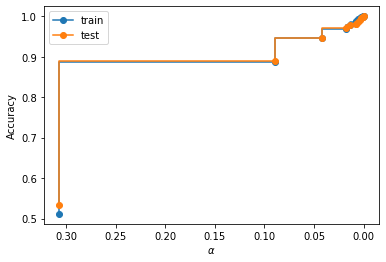

In [18]:
train_scores = [f.score(X_train, y_train) for f in fs]
test_scores  = [f.score(X_test, y_test)   for f in fs]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Accuracy')
#ax.set_title(r'Accuracy vs $\alpha$')
ax.plot(alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(alphas, test_scores,  marker='o', label='test',  drawstyle='steps-post')
ax.invert_xaxis()
ax.legend()
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# grid search
f = DecisionTreeClassifier(random_state=77)
max_depth = range(1, 8, 1)
min_samples_leaf = range(1, 10, 1)
#ccp_alpha = [50, 10, 1.0, 0.1, 0.01, 0]
#ccp_alpha = alphas
param_grid = dict(max_depth = max_depth , min_samples_leaf = min_samples_leaf)
#param_grid = dict(ccp_alpha=alphas)
kfold = KFold(n_splits=10, shuffle=False, random_state=None)
grid_search = GridSearchCV(f, param_grid, scoring = 'accuracy', n_jobs = -1, cv = kfold, verbose = 0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
# see for print(): https://docs.python.org/3/library/stdtypes.html#printf-style-string-formatting
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print('%f with: %r' % (mean, param))

Best: 1.000000 using {'max_depth': 6, 'min_samples_leaf': 1}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 1}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 2}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 3}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 4}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 5}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 6}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 7}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 8}
0.886034 with: {'max_depth': 1, 'min_samples_leaf': 9}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 1}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 2}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 3}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 4}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 5}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 6}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 7}
0.954625 with: {'max_depth': 2, 'min_samples_leaf': 8}
0.95

# Pruned tree

In [24]:
f = DecisionTreeClassifier(
                           criterion='gini',    # 'gini' or 'entropy' impurity functions
#                          max_depth=6,         # maximum depth of the tree
#                          min_samples_split=2, # minimum number of samples required to split an internal node
#                          min_samples_leaf=1,  # minimum number of samples required to be at a leaf node
                           ccp_alpha=0.009,
                           random_state=77
                          )

f = f.fit(X_train, y_train)

print(f)
print('Depth:', f.get_depth())            # depth of the tree
print('No. of leaves:', f.get_n_leaves()) # number of leaves of the tree

# rules of the decision tree
feature_names = list(X_train.columns) # features' names to plot the tree
ft = export_text(f, feature_names=feature_names)
print(ft)

DecisionTreeClassifier(ccp_alpha=0.009, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=77, splitter='best')
Depth: 4
No. of leaves: 6
|--- odor_n <= 0.50
|   |--- stalk-root_c <= 0.50
|   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |--- spore-print-color_u <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- spore-print-color_u >  0.50
|   |   |   |   |--- class: 0
|   |   |--- stalk-surface-below-ring_y >  0.50
|   |   |   |--- class: 0
|   |--- stalk-root_c >  0.50
|   |   |--- class: 0
|--- odor_n >  0.50
|   |--- spore-print-color_r <= 0.50
|   |   |--- class: 0
|   |--- spore-print-color_r >  0.50
|   |   |--- class: 1



# Tree plot

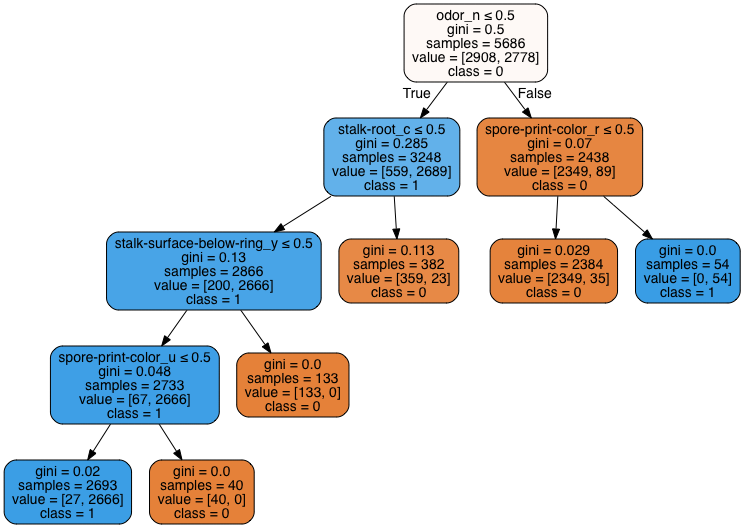

In [21]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(
                f,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names = feature_names,
                class_names=['0','1']
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('tree.png')
Image(graph.create_png())

# Prediction 

In [22]:
import numpy as np

y_pred = f.predict(X_test)
p_pred = f.predict_proba(X_test)

np.concatenate((y_test.reshape(y_test.shape[0],1), y_pred.reshape(y_pred.shape[0],1), p_pred), axis=1)

array([[1.        , 1.        , 0.01002599, 0.98997401],
       [0.        , 0.        , 0.98531879, 0.01468121],
       [1.        , 1.        , 0.01002599, 0.98997401],
       ...,
       [1.        , 1.        , 0.01002599, 0.98997401],
       [0.        , 0.        , 0.98531879, 0.01468121],
       [1.        , 1.        , 0.01002599, 0.98997401]])

# Prediction accuracy

Accuracy: 0.9807219031993437
Confusion Matrix: [[1279   21]
 [  26 1112]]


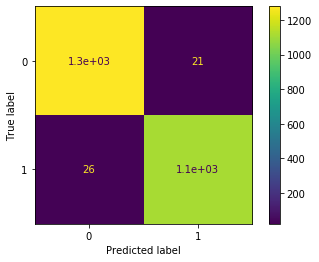

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1138

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438



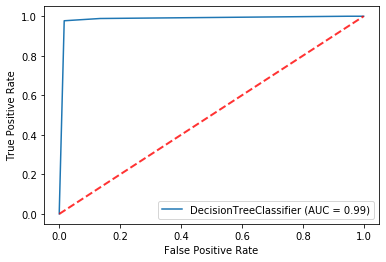

0.9804995268352035

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Confusion Matrix:', metrics.confusion_matrix(y_test, y_pred))
metrics.plot_confusion_matrix(f,X_test,y_test)
plt.show()
print(metrics.classification_report(y_test, y_pred))
#print(metrics.roc_curve(y_test, y_pred))
metrics.plot_roc_curve(f,X_test,y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.show()
metrics.roc_auc_score(y_test, y_pred)